# FuncX Roundtrip Execution Time

The goal is to understand how ProxyStore can reduce FuncX task round trip time by avoiding data transfer through the cloud.

The takeaway is that execution time can be greatly improved with minimal code (2 lines: one to initialize ProxyStore and one to `proxy`).

Parameters:
- Client/Endpoint location: both ALCF, both NERSC, one in each
- Data size: 0 bytes to 100 MB
- Task type: no-op and sleep where proxy is async resolved
- PS backend

Notes:
- This experiment represents worst case scenario for ProxyStore+FuncX because tasks are executed serially so there is no overlapping of ProxyStore communication with waiting on FuncX tasks.

## Instructions

### Setup

Setup needs to be performed on all sites that will be used.

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a FuncX endpoint. Note that the endpoint configuration will need to be changed customized for the system, allocations, etc.
   ```bash
   $ funcx-endpoint configure psbench
   $ funcx-endpoint start psbench
   ```
   Endpoint config reference: https://funcx.readthedocs.io/en/latest/endpoints.html
3. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench --server {SIGNALING SERVER}
   $ proxystore-endpoint start psbench &> /dev/null &
   ```
   Note: endpoint logs will still be written to ~/.proxystore

### Run

```bash
$ python -m psbench.benchmarks.funcx_tasks \
    --funcx-endpoint {UUID} \  # UUID returned by funcx-endpoint start
    --task-repeat 5 \
    --task-sleep 0.0 \
    --input-sizes 100 1000 10000 \
    --output-sizes 0 \
    --ps-backend ENDPOINT --ps-endpoints {UUID} {UUID} \ # UUIDs for all ProxyStore endpoints
    --csv-file {OUTPUT-CSV-FILE}
```

### Notes

- All experiments done with Python 3.9
- proxystore-benchmark commit hash used: `bf643cd2dee85e243f92c824cd701ee02ac8ace5`
- When a job is needed for a worker, its best to run a small benchmark to allocate nodes then run the benchmark for real.

In [88]:
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas

plt.style.use('seaborn-colorblind')

In [89]:
BACKEND_COLUMN = 'proxystore_backend'
INPUT_SIZE_COLUMN = 'input_size_bytes'
TOTAL_TIME_COLUMN = 'total_time_ms'
SLEEP_COLUMN = 'task_sleep_seconds'

def load(filepath: str) -> pandas.DataFrame:
    df = pandas.read_csv(filepath)
    df[BACKEND_COLUMN] = df[BACKEND_COLUMN].fillna('FuncX')
    return df

In [90]:
theta_theta_noop_data = load('data/funcx-roundtrip/noop-thetalogin5-thetalogin5.csv')
theta_theta_sleep_data = load('data/funcx-roundtrip/sleep-thetalogin5-thetalogin5.csv')
perlmutter_perlmutter_noop_data = load('data/funcx-roundtrip/noop-perlmutterlogin24-perlmutter.csv')
perlmutter_perlmutter_sleep_data = load('data/funcx-roundtrip/sleep-perlmutterlogin24-perlmutter.csv')
rows_matching_column_value(theta_theta_noop_data, BACKEND_COLUMN, 'FileStore').head()

,proxystore_backend,task_name,input_size_bytes,output_size_bytes,task_sleep_seconds,total_time_ms,input_get_ms,input_set_ms,input_proxy_ms,input_resolve_ms,output_get_ms,output_set_ms,output_proxy_ms,output_resolve_ms
105,FileStore,pong,0,0,0.0,1674.669396,0.885793,1.914428,1.979657,1.877856,1.346535,1.895322,1.918871,1.386648
106,FileStore,pong,0,0,0.0,464.884779,0.897694,1.906500,1.936117,1.309918,1.096823,1.516907,1.537496,1.119387
107,FileStore,pong,0,0,0.0,577.652533,1.031897,1.737206,1.770516,1.497532,0.887713,1.870498,1.900390,0.906950
108,FileStore,pong,0,0,0.0,457.776396,0.876193,1.734527,1.771336,1.278990,1.056296,1.527945,1.547599,1.069959
109,FileStore,pong,0,0,0.0,485.763425,1.033978,1.745352,1.804801,1.481210,0.883759,1.962646,1.983176,0.907027


In [91]:
def get_backends(data: pandas.DataFrame) -> list[str]:
    return data[BACKEND_COLUMN].unique()

def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_input_sizes(data: pandas.DataFrame) -> list[int]:
    return list(data[INPUT_SIZE_COLUMN].unique())

def get_avg_total_time(data: pandas.DataFrame) -> float:
    """Drops min/max and takes average of remaining times."""
    times = list(data[TOTAL_TIME_COLUMN])
    if len(times) < 3:
        raise ValueError('Cannot drop min/max value when row count < 3')
    times.remove(min(times))
    times.remove(max(times))
    return sum(times) / len(times)

def extract_avg_times(data: pandas.DataFrame) -> dict[str, list[str]]:
    # Input dataframe should just contain one backend type
    assert len(get_backends(data)) == 1
    input_sizes = get_input_sizes(data)
    input_sizes
    avg_times = [
        get_avg_total_time(rows_matching_column_value(data, INPUT_SIZE_COLUMN, input_size)) for input_size in input_sizes
    ]
    # Convert to seconds
    avg_times = [x / 1000 for x in avg_times]
    return {'sizes': input_sizes, 'times': avg_times}

def extract(data: pandas.DataFrame) -> dict[str, dict[str, list[str]]]:
    result = {}
    for backend in get_backends(data):
        subset = rows_matching_column_value(data, BACKEND_COLUMN, backend)
        result[backend] = extract_avg_times(subset)
    return result

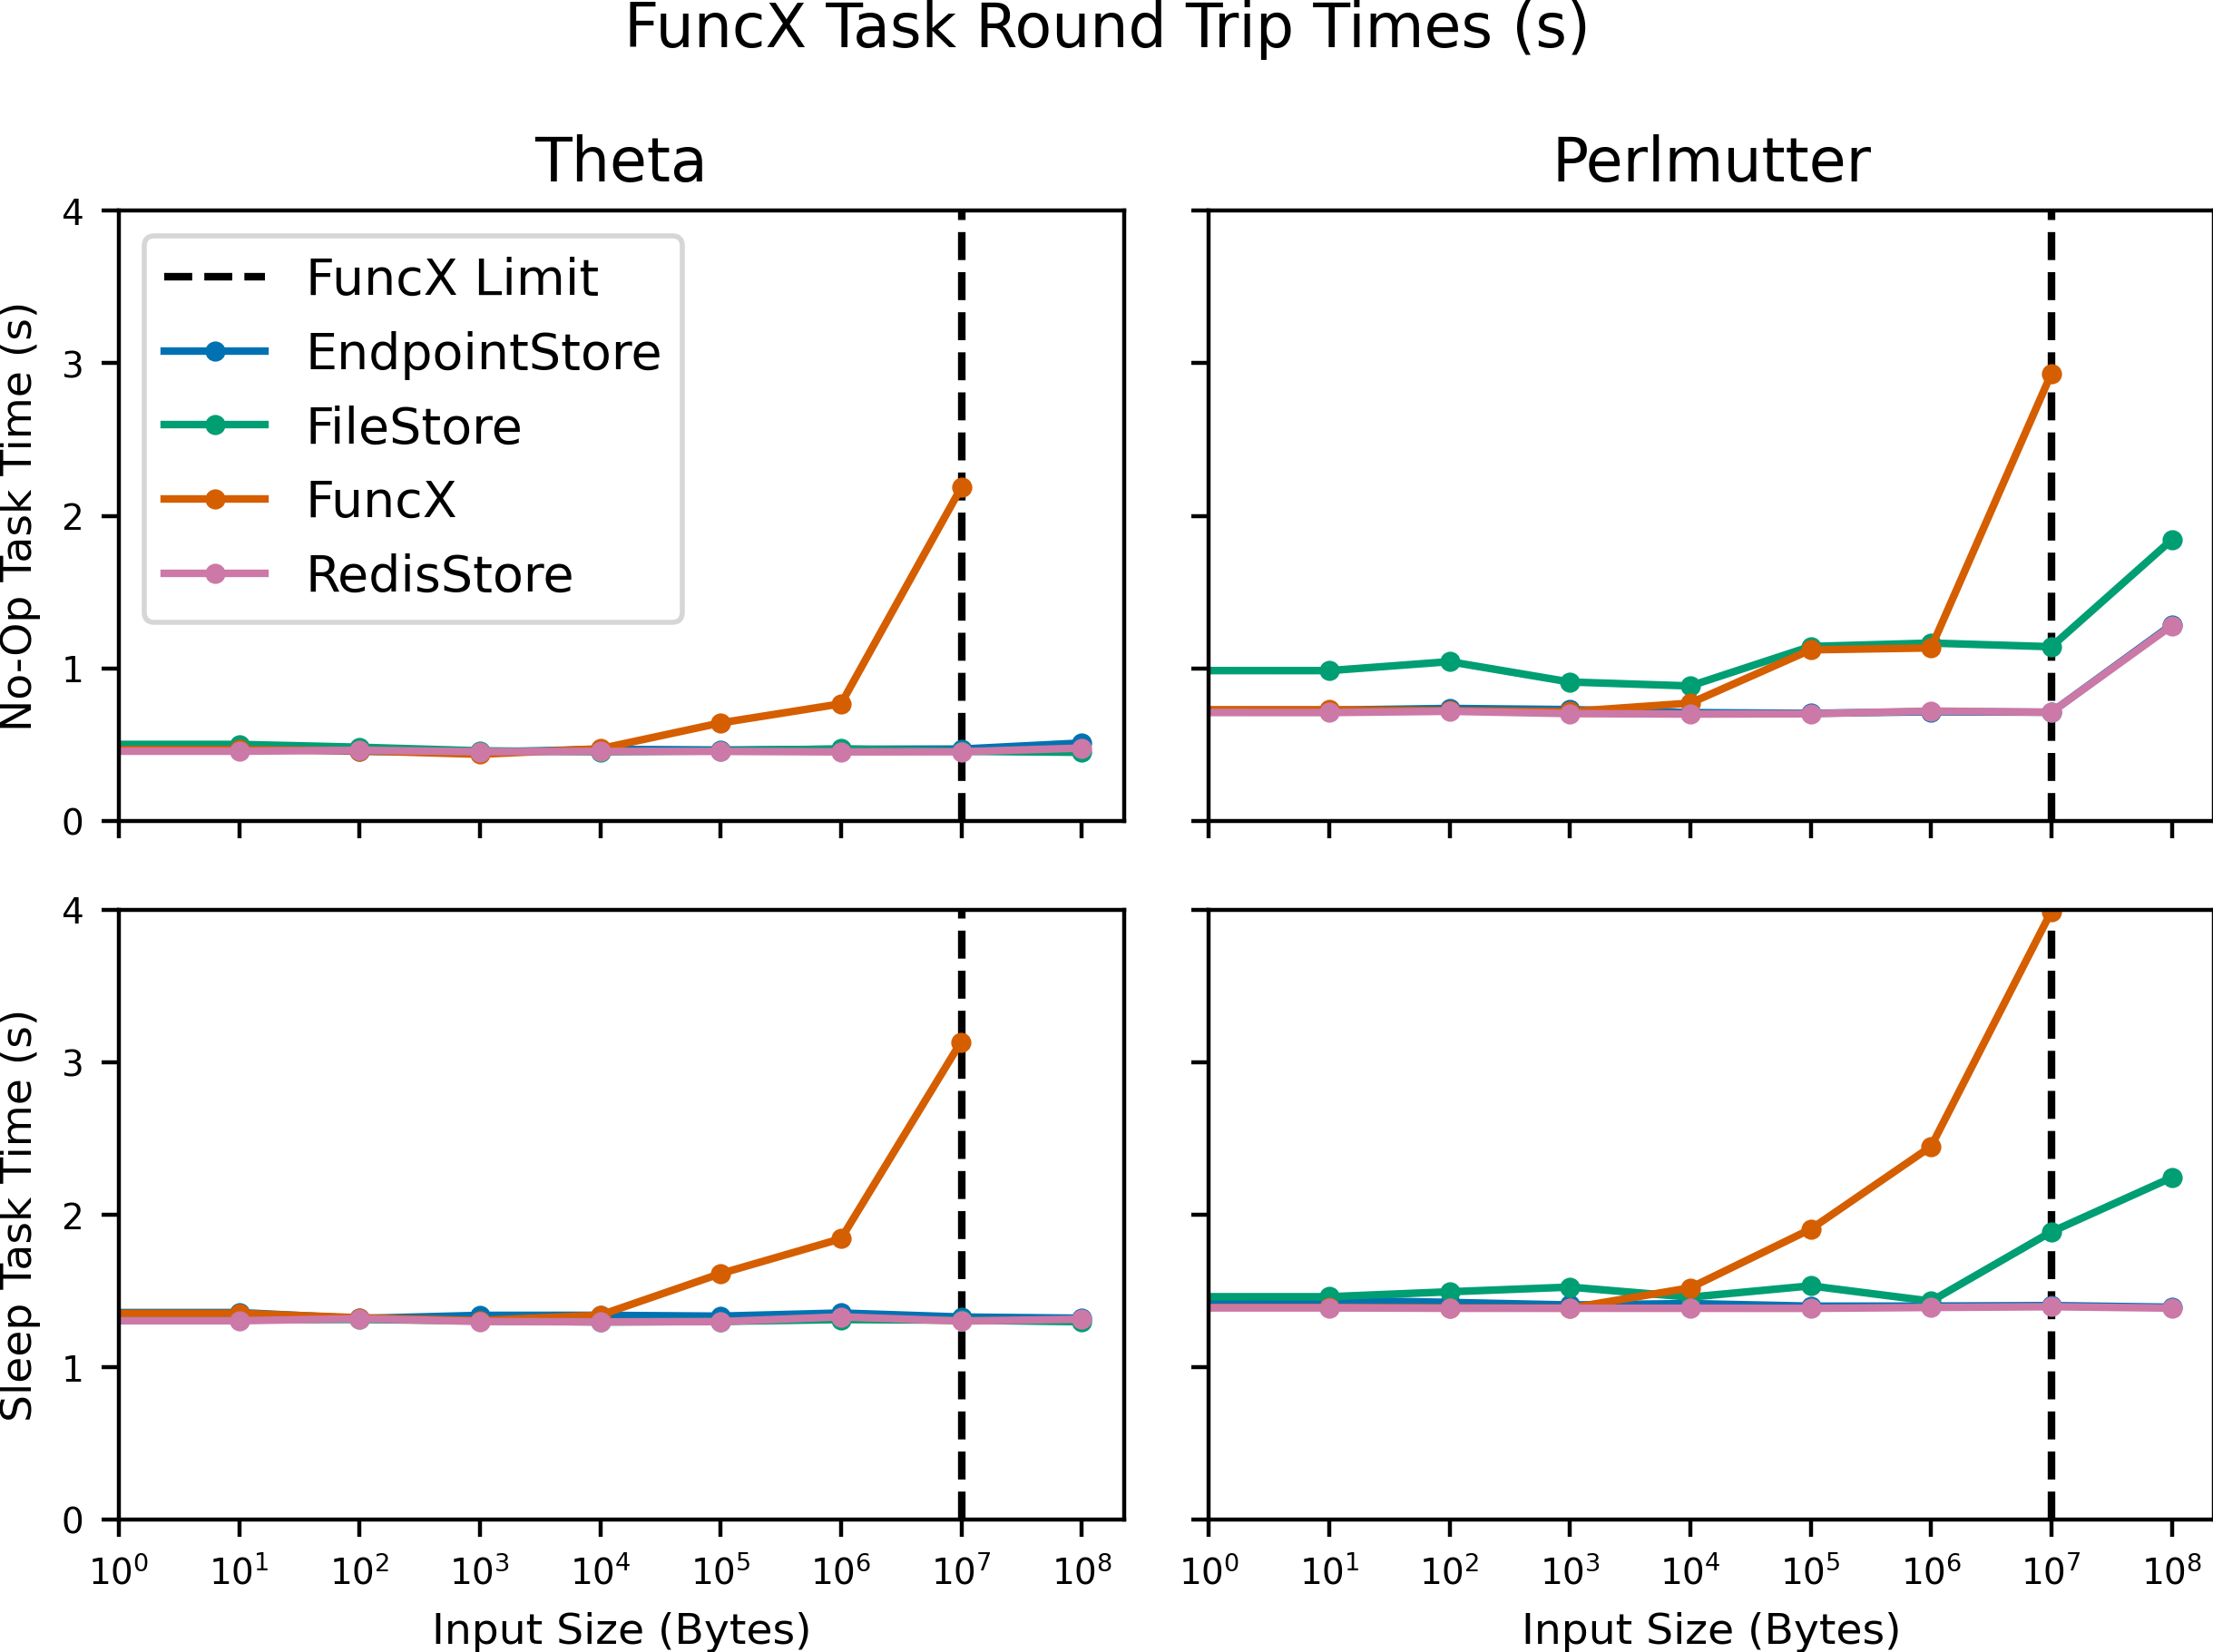

In [92]:
extracted_data = [
    [extract(theta_theta_noop_data), extract(perlmutter_perlmutter_noop_data)],
    [extract(theta_theta_sleep_data), extract(perlmutter_perlmutter_sleep_data)],
]

rows = 2
cols = 2

fig, axs = plt.subplots(rows, cols, sharex=True, sharey='row')

for i in range(rows):
    for j in range(cols):
        ax = axs[i, j]
        data = extracted_data[i][j]
        
        ax.axvline(1e7, color='black', linestyle='--', label='FuncX Limit')
        
        for backend in sorted(data):
            xy = [(x, y) for x, y in zip(data[backend]['sizes'], data[backend]['times']) if x < 1e9]
            x, y  = zip(*xy)
            ax.plot(x, y, marker='.', label=backend)

        #ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xticks([10 ** x for x in range(0, 9)])

plt.suptitle('FuncX Task Round Trip Times (s)')

axs[1, 0].set_xlabel('Input Size (Bytes)')
axs[1, 1].set_xlabel('Input Size (Bytes)')
axs[0, 0].set_ylabel('No-Op Task Time (s)')
axs[1, 0].set_ylabel('Sleep Task Time (s)')
axs[0, 0].set_title('Theta')
axs[0, 1].set_title('Perlmutter')
axs[0, 0].legend(loc='upper left')

# Restrict y axis range
axs[0, 0].set_ylim([0, 4])
axs[1, 0].set_ylim([0, 4])

# Restrict y labels to integers
axs[0, 0].get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))
axs[1, 0].get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))

fig.tight_layout()

plt.savefig('figures/funcx-roundtrip-task-times.png')